### Задание 2
Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!

- Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
- Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.
- Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте их тоже указать.

### Итак, начнем:

Я выбрала DAU в качестве ключевой метрики для прогнозирования нагрузки на серверы, так как считаю, что эта метрика напрямую коррелирует с числом активных сессий и запросов к серверу. В отличие от таких метрик как просмотры или лайки, которые зависят от поведения пользователей и могут варьироваться в широких пределах, DAU дает четкое представление о масштабах нагрузки на систему.

Я выбрала дневное разрешение для данной задачи, так как оно устойчивее к случайным колебаниям и соответствует циклу принятия инфраструктурных решений - большинство решений о масштабировании принимаются на основе суточных данных.

Для того, чтобы предсказывать модель вместе с регрессором, нужно знать будущие значения этого регрессора, а мы их не знаем, поэтому для этой задачи регрессор использоваться не будет.

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.eda import eda_plot
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
import arviz as az #это полезно для визуализации MCMC

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250320'
}

In [3]:
query = '''
SELECT 
    toDate(time) AS date,
    uniqExact(user_id) AS DAU
FROM {db}.feed_actions
WHERE toDate(time) < '2025-04-02'
GROUP BY date
ORDER BY date
'''

In [4]:
df = ph.read_clickhouse(query=query, connection=connection)
df.head()

,date,DAU
0,2025-01-25,878
1,2025-01-26,2238
2,2025-01-27,3105
3,2025-01-28,3721
4,2025-01-29,4617


In [7]:
#зададим рисовательный шаблон для сиборна
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

<Axes: xlabel='date', ylabel='DAU'>

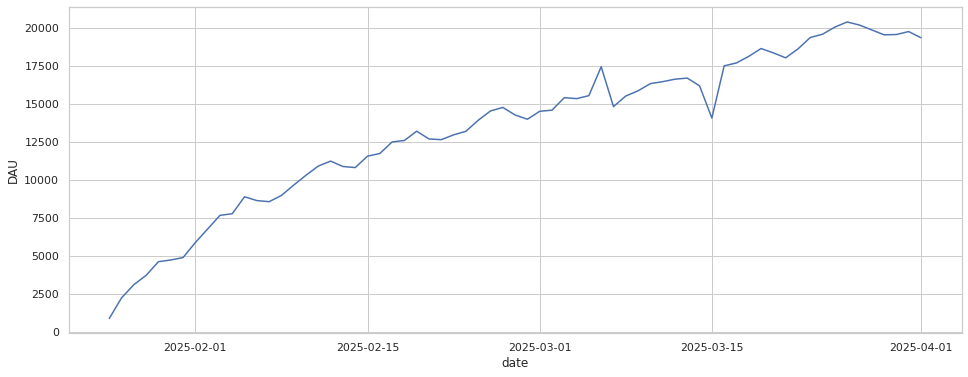

In [8]:
#как менялся DAU
sns.lineplot(x="date", y="DAU", data=df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

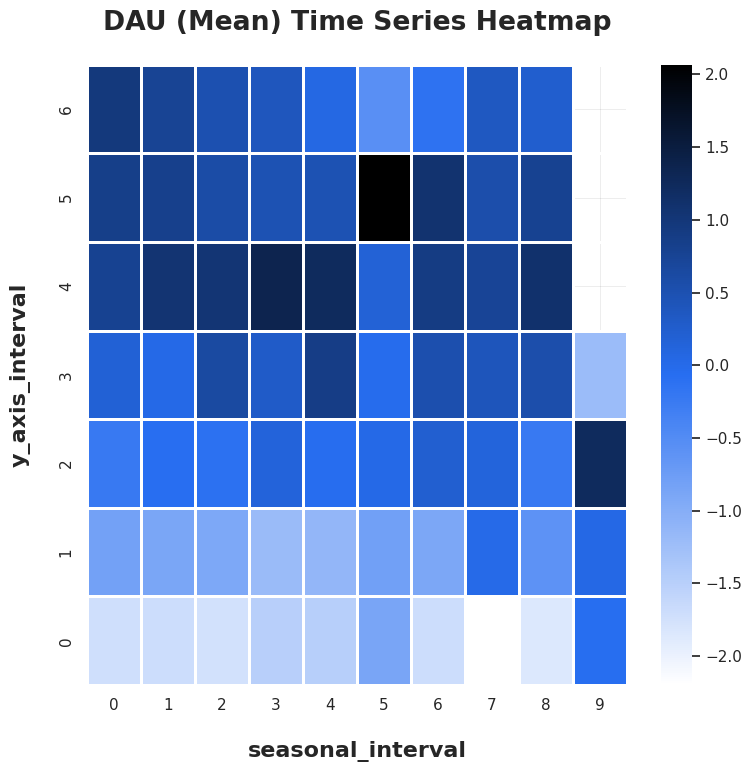

In [9]:
# Посмотрим тепловую карту
_ = eda_plot.ts_heatmap(
    df=df,
    date_col="date",  # Дата в дневном разрешении
    value_col="DAU",
    seasonal_interval=7,  # Анализ по дням недели
    normalization=True  # Нормировка для сравнения разных периодов
)

### Строим модель Damped Local Trend

#### 1. Используем алгоритм Maximum A Posteriori

In [10]:
dlt = DLT(response_col="DAU", #название колонки с метрикой
          date_col="date", #название колонки с датами-временем
          seasonality=7, #длина периода сезонности 
          estimator="stan-map", #алгоритм оценки
          n_bootstrap_draws=1000) #количество сэмплов бутстрапа для доверительного интервала

2025-04-05 07:36:13 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.


In [11]:
dlt.fit(df) #тут мы указываем данные, на которых строится модель

2025-04-05 07:37:36 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


In [14]:
future_df = dlt.make_future_df(periods=30)  # 30 дней

In [15]:
predicted_df = dlt.predict(df=future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

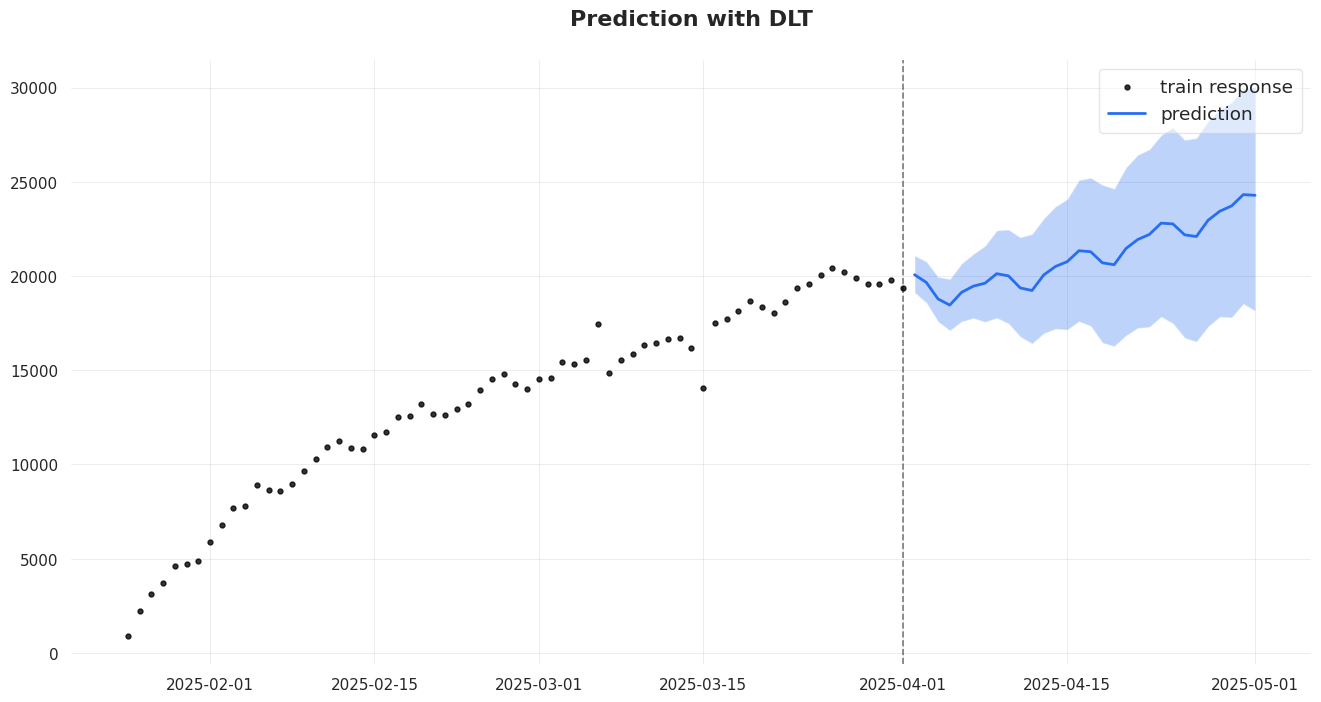

In [16]:
_ = plot_predicted_data(df, #изначальные данные
                        predicted_df, #датафрейм с предсказаниями
                        "date", #колонка со временем
                        'DAU', #колонка со значениями временного ряда
                        title='Prediction with DLT') #заголовок рисунка

In [20]:
predicted_df = dlt.predict(df=future_df, 
                           decompose=True)
predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-04-02,19043.198353,20070.166217,20913.777272,18378.780353,19405.748217,20249.359272,664.418,664.418,664.418,0.0,0.0,0.0
1,2025-04-03,18575.946997,19660.269411,20627.460047,18166.253997,19250.576411,20217.767047,409.693,409.693,409.693,0.0,0.0,0.0
2,2025-04-04,17504.314847,18784.697110,19896.134148,17889.731847,19170.114110,20281.551148,-385.417,-385.417,-385.417,0.0,0.0,0.0
3,2025-04-05,17117.537099,18456.851411,19846.497409,17810.105099,19149.419411,20539.065409,-692.568,-692.568,-692.568,0.0,0.0,0.0
4,2025-04-06,17604.024756,19131.557795,20684.260458,17649.005756,19176.538795,20729.241458,-44.981,-44.981,-44.981,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

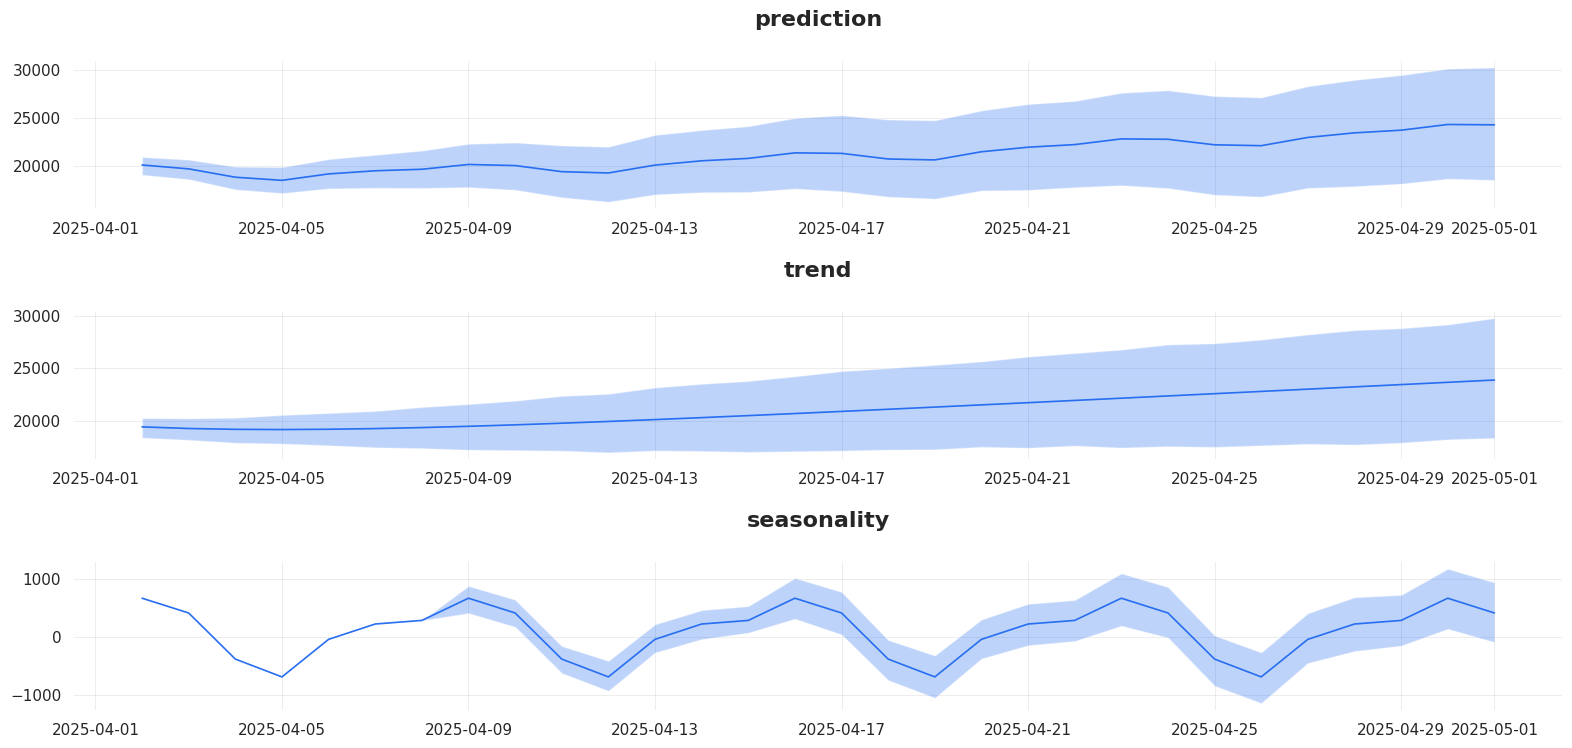

In [21]:
_ = plot_predicted_components(predicted_df, "date", plot_components=['prediction', 'trend', 'seasonality'])

#### 2. Используем алгоритм Markov Chain Monte Carlo

In [22]:
dlt_mcmc = DLT(seasonality=7,
               response_col="DAU",
               date_col="date", 
               estimator='stan-mcmc', #новый алгоритм оценки
               num_warmup=2000, #время "разогрева"
               num_sample=1000) #время сэмплирования

In [23]:
dlt_mcmc.fit(df) #тут мы указываем данные, на которых строится модель

2025-04-05 07:39:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [25]:
predicted_df_mcmc = dlt_mcmc.predict(df=future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

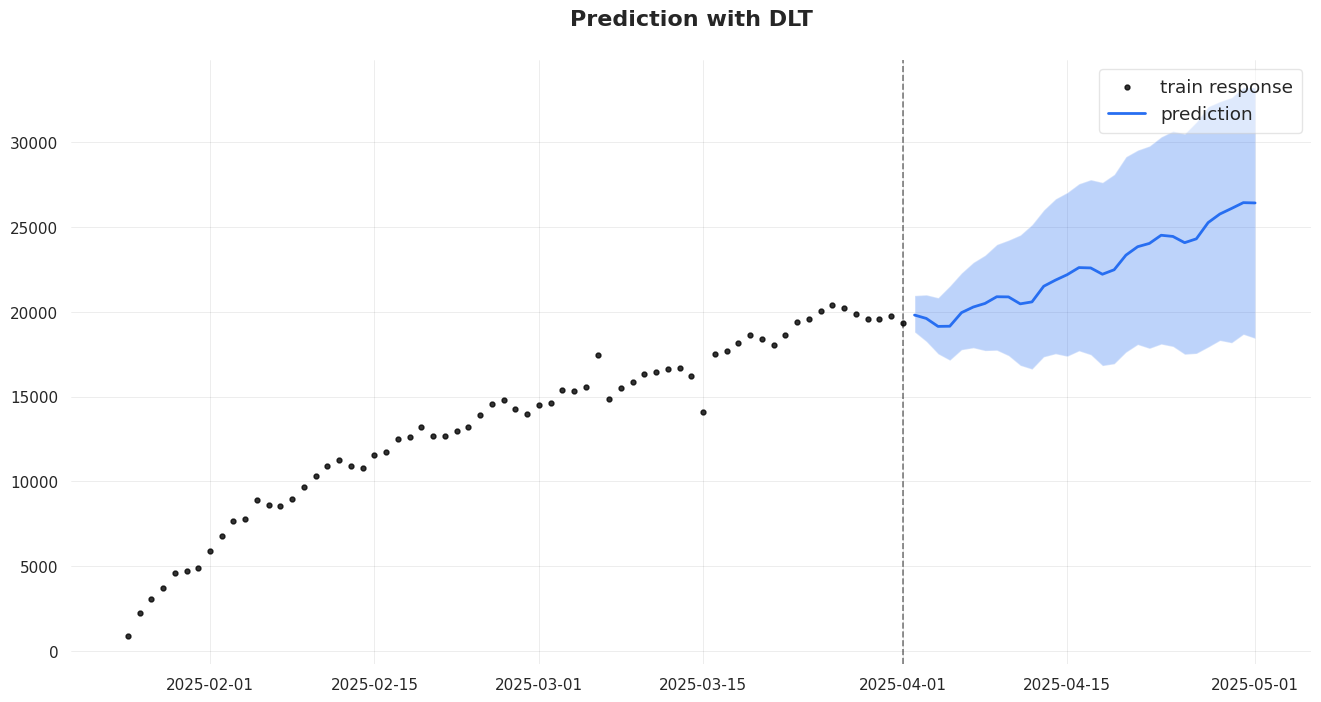

In [26]:
_ = plot_predicted_data(df, #изначальные данные
                        predicted_df_mcmc, #датафрейм с предсказаниями
                        "date", #колонка со временем
                        'DAU', #колонка со значениями временного ряда
                        title='Prediction with DLT') #заголовок рисунка

In [27]:
predicted_df_mcmc = dlt_mcmc.predict(df=future_df, 
                           decompose=True)
predicted_df_mcmc.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-04-02,18742.762285,19737.126920,20924.168985,18345.295283,19411.948395,20497.826880,16.4226,324.38200,862.805700,0.0,0.0,0.0
1,2025-04-03,18233.257234,19604.601532,20901.713313,18089.669444,19477.782734,20853.057467,-167.7475,18.75205,600.024000,0.0,0.0,0.0
2,2025-04-04,17368.164189,19054.002378,20726.593236,17793.037163,19536.085717,21231.967076,-767.1080,-479.24550,-74.738045,0.0,0.0,0.0
3,2025-04-05,16984.568201,19157.541727,21238.518537,17634.002793,19681.029476,21637.817268,-1015.1290,-536.35000,-28.309300,0.0,0.0,0.0
4,2025-04-06,17720.617099,19829.478342,22202.242280,17609.693120,19821.189913,22113.618333,-361.3620,126.00250,365.768450,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

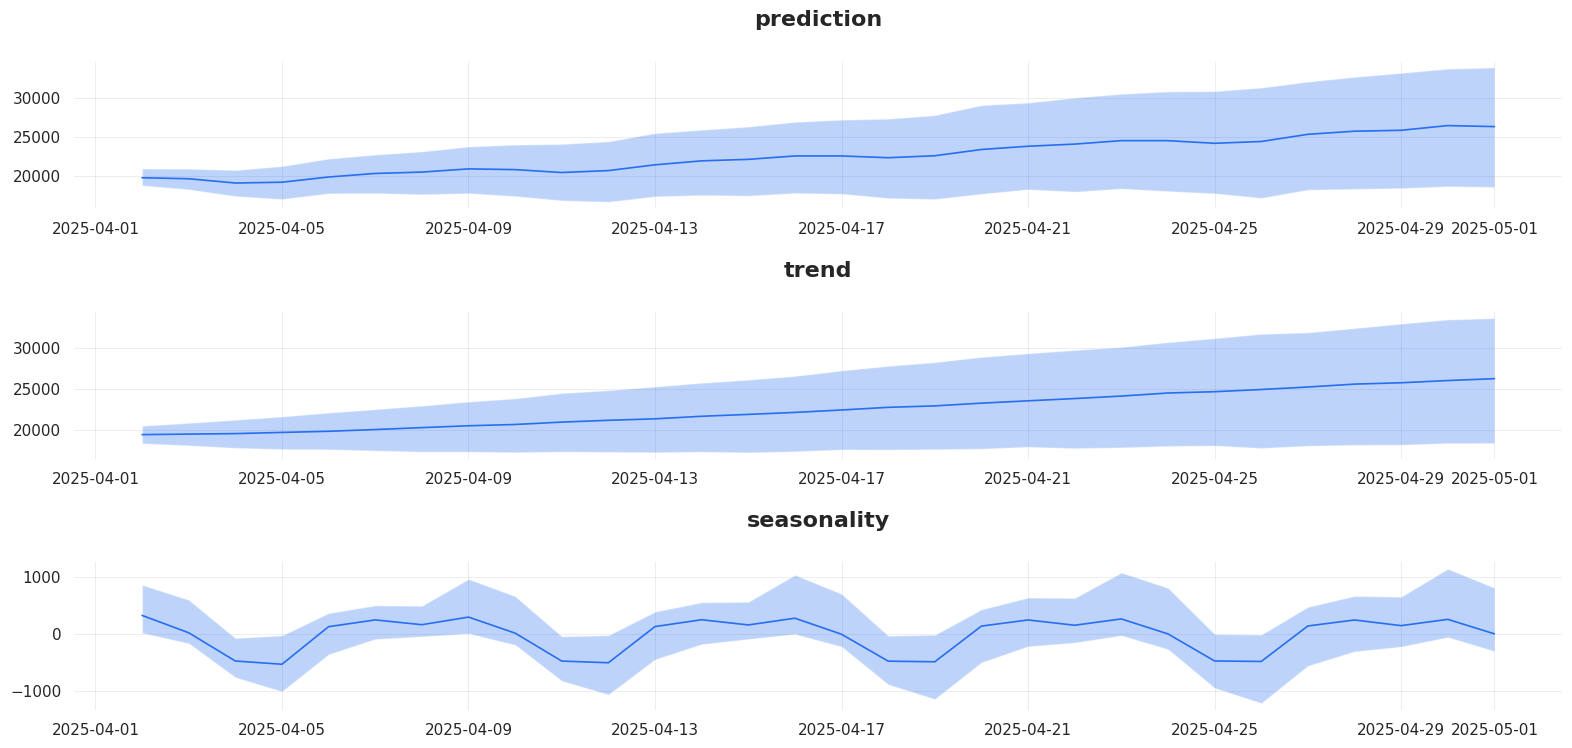

In [28]:
_ = plot_predicted_components(predicted_df_mcmc, "date", plot_components=['prediction', 'trend', 'seasonality'])

#### Проведем бэктестинг имеющихся моделей.

Для надежного 30-дневного прогнозирования объем данных недостаточен. В текущих условиях наиболее обоснованным будет проведение бэктестирования на горизонте 7-14 дней, что позволяет получить статистически значимые результаты при сохранении 4-5 итераций проверки. 

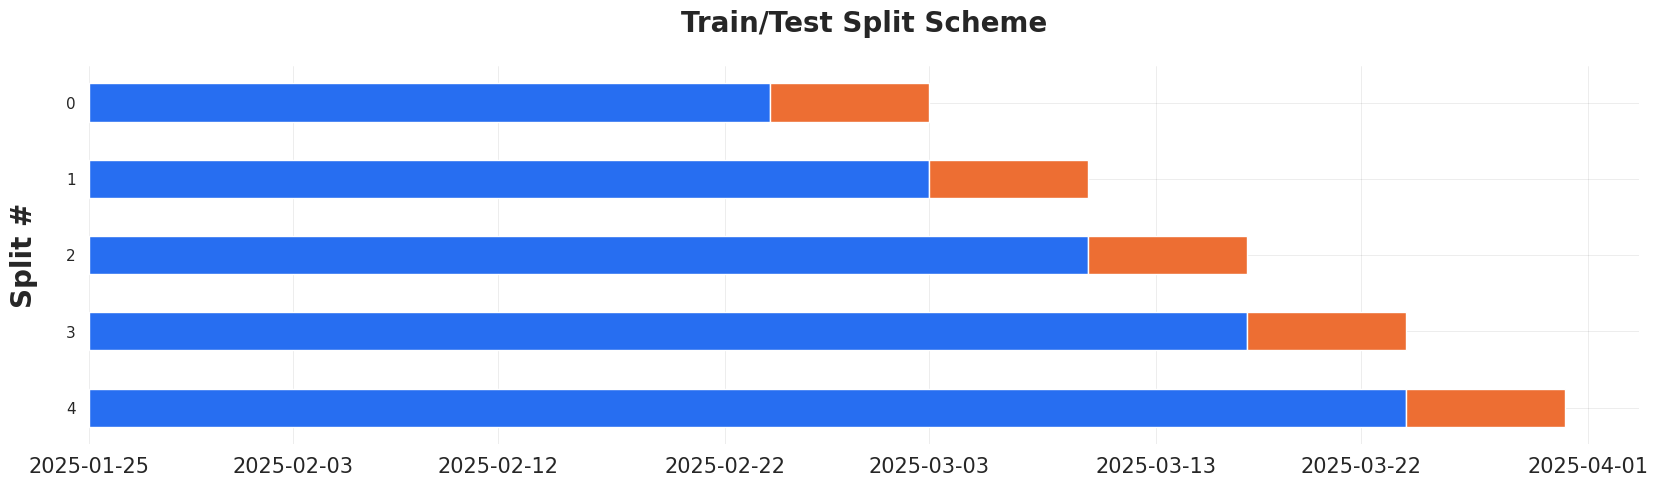

In [29]:
#expanding

bt_exp = BackTester(
    model=dlt, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=30, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)
bt_exp.plot_scheme()

In [30]:
bt_exp.fit_predict() #обучаем
score_map = bt_exp.score()
score_map #выводим метрики для модели map

,metric_name,metric_values,is_training_metric
0,smape,5.794307e-02,False
1,wmape,5.795515e-02,False
2,mape,5.884496e-02,False
3,mse,1.293474e+06,False
4,mae,9.814043e+02,False
5,rmsse,1.173790e+00,False


In [31]:
bt_exp_mcmc = BackTester(
    model=dlt_mcmc, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=30, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [32]:
bt_exp_mcmc.fit_predict() #обучаем
score_mcmc = bt_exp_mcmc.score() 
score_mcmc #выводим метрики для модели мсмс

2025-04-05 07:41:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-04-05 07:41:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-04-05 07:41:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-04-05 07:41:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-04-05 07:41:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,4.856043e-02,False
1,wmape,4.909469e-02,False
2,mape,4.948968e-02,False
3,mse,1.081056e+06,False
4,mae,8.313625e+02,False
5,rmsse,1.073089e+00,False


#### Дополнительно проведем проверку сходимости цепей нашего алгоритма MCMC

In [33]:
params = dlt_mcmc.get_posterior_samples(permute=False)
params["obs_sigma"].shape

(4, 250)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

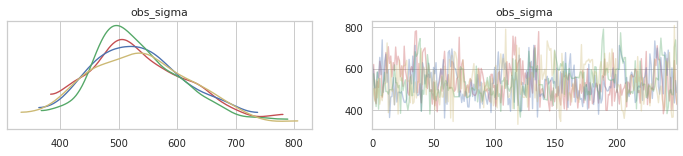

In [34]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

#### Сравним модели

In [37]:
# Посчитаем разницу метриках
diff_metrics = score_mcmc.set_index('metric_name')['metric_values'] -  score_map.set_index('metric_name')['metric_values']
diff_metrics

metric_name
smape        -0.009383
wmape        -0.008860
mape         -0.009355
mse     -212417.392946
mae        -150.041794
rmsse        -0.100701
Name: metric_values, dtype: float64

In [38]:
# Посчитаем разницу метриках в процентах
improvement_pct = ((score_map.set_index('metric_name')['metric_values'] - score_mcmc.set_index('metric_name')['metric_values'])
                   / score_map.set_index('metric_name')['metric_values']) * 100
improvement_pct

metric_name
smape    16.192855
wmape    15.288480
mape     15.898196
mse      16.422242
mae      15.288480
rmsse     8.579128
Name: metric_values, dtype: float64

#### MCMC выигрывает по всем метрикам, так как лучше учитывает неопределенность в данных и находит более точные параметры модели. Далее буду использовать его. Теперь попробую поменять тип тренда.

In [39]:
dlt_mcmc_loglin = DLT(
               seasonality=7,
               response_col="DAU",
               date_col="date", 
               estimator='stan-mcmc', #новый алгоритм оценки
               global_trend_option = "loglinear",  # другой тип тренда
               num_warmup=2000, #время "разогрева"
               num_sample=1000) #время сэмплирования

In [40]:
dlt_mcmc_loglin.fit(df)

2025-04-05 07:43:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [41]:
predicted_df_loglin = dlt_mcmc_loglin.predict(df=future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

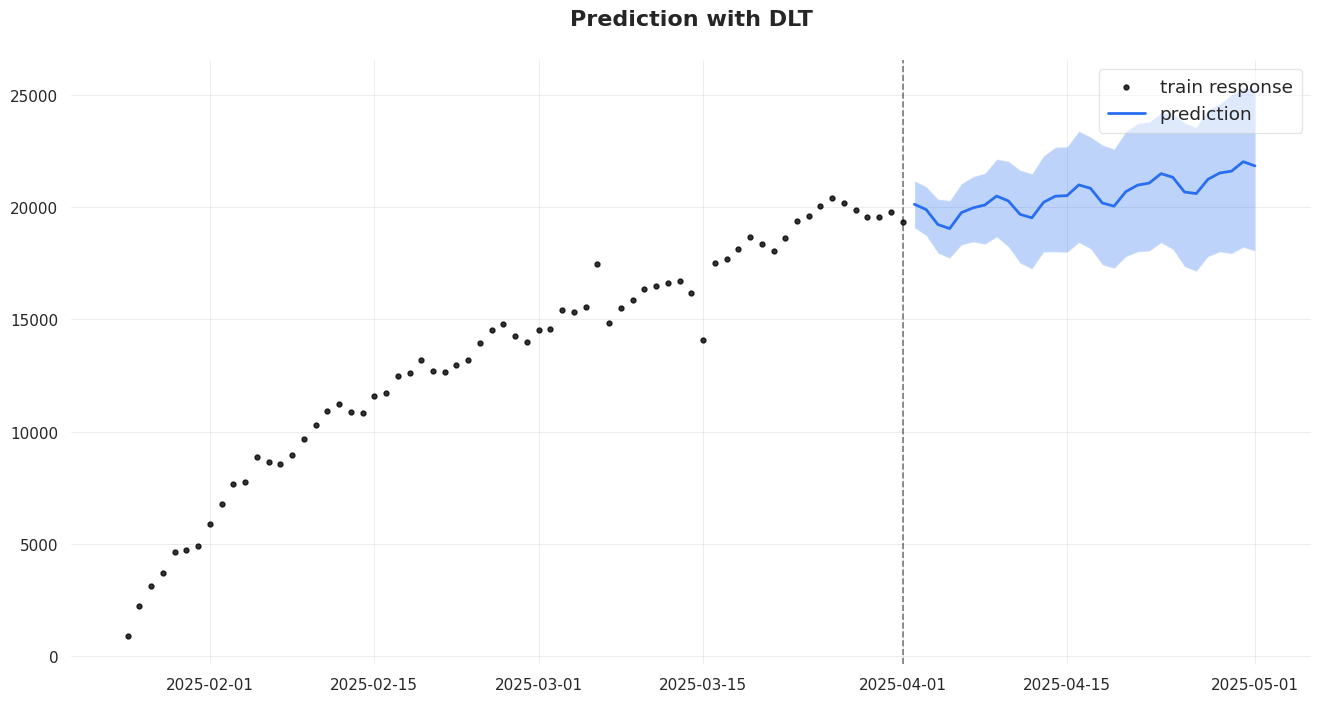

In [42]:
_ = plot_predicted_data(df, #изначальные данные
                        predicted_df_loglin, #датафрейм с предсказаниями
                        "date", #колонка со временем
                        'DAU', #колонка со значениями временного ряда
                        title='Prediction with DLT') #заголовок рисунка

In [51]:
predicted_df_loglin = dlt_mcmc_loglin.predict(df=future_df, 
                           decompose=True) 
predicted_df_loglin.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2025-04-02,18974.077391,20098.024107,21163.474648,18451.321004,19496.781928,20551.900083,203.971150,612.37400,940.913450,0.0,0.0,0.0
1,2025-04-03,18791.674226,19872.549729,20930.059695,18467.474837,19521.361323,20592.951799,-24.649605,351.55400,675.760750,0.0,0.0,0.0
2,2025-04-04,18025.405399,19202.319339,20357.876773,18368.911480,19555.033201,20752.882322,-589.217200,-381.12050,-41.544615,0.0,0.0,0.0
3,2025-04-05,17684.342616,18971.965406,20296.922459,18254.853842,19576.244125,20889.101391,-826.253350,-587.25500,-236.358600,0.0,0.0,0.0
4,2025-04-06,18273.044786,19740.490570,21033.916137,18156.800335,19708.371842,20999.891687,-174.698850,57.25355,297.452600,0.0,0.0,0.0


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

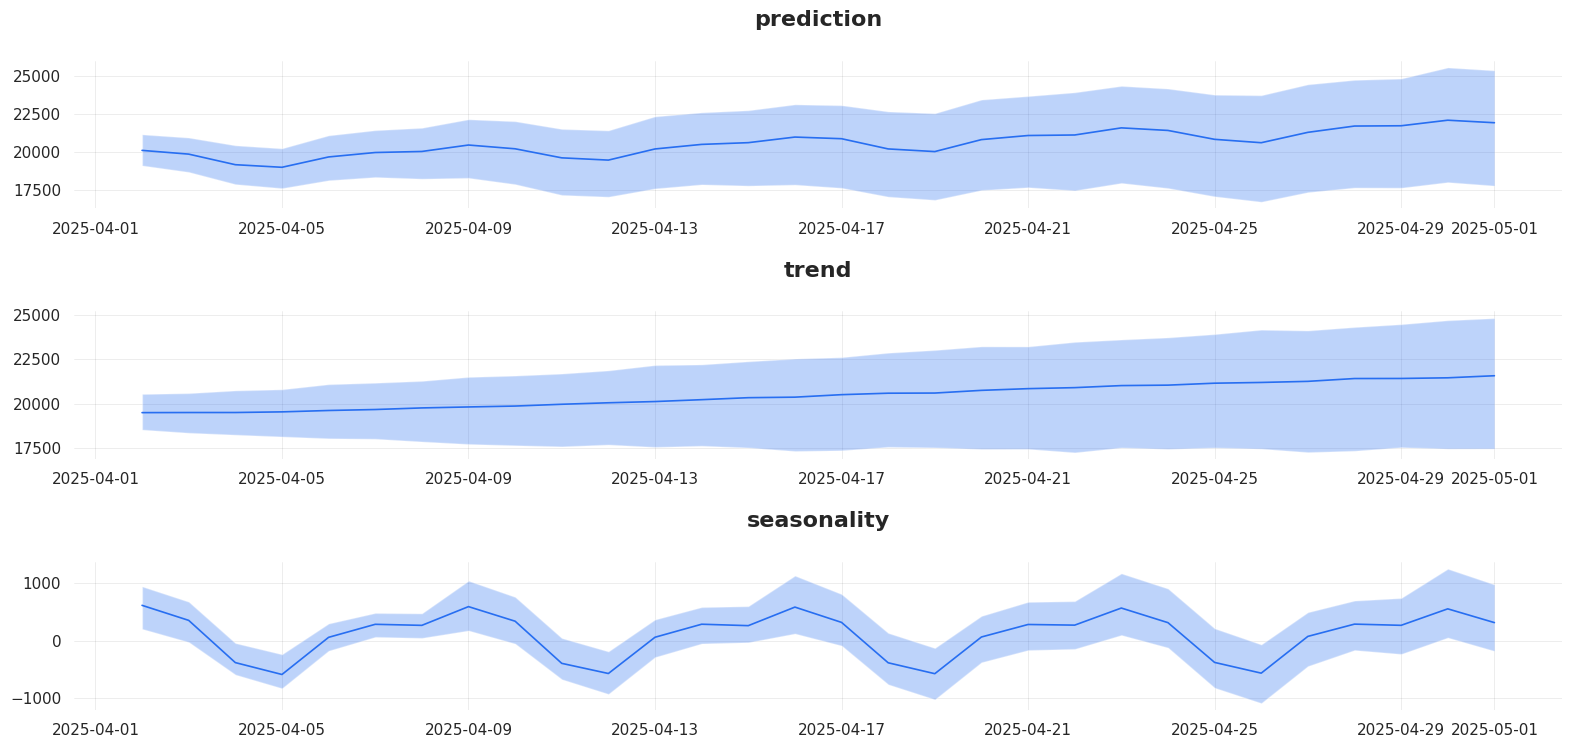

In [44]:
_ = plot_predicted_components(predicted_df_loglin, "date", plot_components=['prediction', 'trend', 'seasonality'])

In [45]:
# Проверим бэктестингом
bt_exp_loglin = BackTester(
    model=dlt_mcmc_loglin, #наша моделька
    df=df, #датафрейм для обучения
    min_train_len=30, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="expanding" #тип окошка
)

In [46]:
bt_exp_loglin.fit_predict() #обучаем
score_loglin = bt_exp_loglin.score() 
score_loglin #выводим метрики для модели 

2025-04-05 07:45:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-04-05 07:45:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-04-05 07:45:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-04-05 07:45:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-04-05 07:45:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

,metric_name,metric_values,is_training_metric
0,smape,0.035021,False
1,wmape,0.035561,False
2,mape,0.034783,False
3,mse,739278.370303,False
4,mae,602.180629,False
5,rmsse,0.887393,False


#### Сравним модели

In [47]:
# Посчитаем разницу метриках
diff_metrics = score_loglin.set_index('metric_name')['metric_values'] -  score_mcmc.set_index('metric_name')['metric_values']
diff_metrics

metric_name
smape        -0.013540
wmape        -0.013534
mape         -0.014706
mse     -341778.039473
mae        -229.181846
rmsse        -0.185697
Name: metric_values, dtype: float64

In [49]:
# Посчитаем разницу метриках в процентах
improvement_pct = ((score_mcmc.set_index('metric_name')['metric_values'] - score_loglin.set_index('metric_name')['metric_values'])
                   / score_mcmc.set_index('metric_name')['metric_values']) * 100
improvement_pct

metric_name
smape    27.882201
wmape    27.567018
mape     29.715893
mse      31.615190
mae      27.567018
rmsse    17.304891
Name: metric_values, dtype: float64

#### MCMC с логлинейным трендом — оптимальный выбор для наших данных, так как она лучше всего отражает нелинейную природу DAU и улучшение качества прогноза на 27-31% для большинства метрик.

#### Вывод: модель показывает выраженные колебания активности, что позволяет заранее подготовить инфраструктуру к периодам пиковой нагрузки и оптимизировать затраты в периоды снижения активности.